In [ ]:
# Imports required libraries for data manipulation, visualization, and deep learning
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

# Defines a learning rate scheduler for model training
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

# Iterates through files in the input directory (Kaggle environment)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
# Defines the directories for each class of MRI images
AD_dir = r'/kaggle/input/alzheimer-mri-axial-images/Axial/AD'
CI_dir = r'/kaggle/input/alzheimer-mri-axial-images/Axial/CI'
CN_dir = r'/kaggle/input/alzheimer-mri-axial-images/Axial/CN'

# Initializes lists to store file paths and corresponding labels
filepaths = []
labels = []
dict_list = [AD_dir, CI_dir, CN_dir]
class_labels = ['AD', 'CI', 'CN']

# Collects file paths and assigns labels for each class
for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

# Creates a DataFrame containing file paths and labels
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)

# Displays the first few rows and the distribution of labels
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths labels
0  /kaggle/input/alzheimer-mri-axial-images/Axial...     AD
1  /kaggle/input/alzheimer-mri-axial-images/Axial...     AD
2  /kaggle/input/alzheimer-mri-axial-images/Axial...     AD
3  /kaggle/input/alzheimer-mri-axial-images/Axial...     AD
4  /kaggle/input/alzheimer-mri-axial-images/Axial...     AD
labels
CI    2590
CN    1440
AD    1124
Name: count, dtype: int64


In [ ]:
# Displays the shape of the DataFrame (number of samples and columns)
Alzheimer_df.shape

(5154, 2)

In [ ]:
# Splits the data into training, validation, and test sets
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [ ]:
# Prints the shapes of the training, validation, and test sets
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(4123, 2)
(1547, 2)
(1031, 2)
(3607, 2)


In [ ]:
# Creates an ImageDataGenerator for preprocessing images
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

# Generates batches of image data for training, validation, and testing
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", # Used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            # Do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 4123 validated image filenames belonging to 3 classes.
Found 1547 validated image filenames belonging to 3 classes.
Found 1031 validated image filenames belonging to 3 classes.


In [ ]:
# Extracts and prints the class names from the training data generator
classes=list(train.class_indices.keys())
print (classes)

['AD', 'CI', 'CN']


In [ ]:
# Defines a function to display a grid of sample images with their class labels
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)  # Gets a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2  # Scales images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

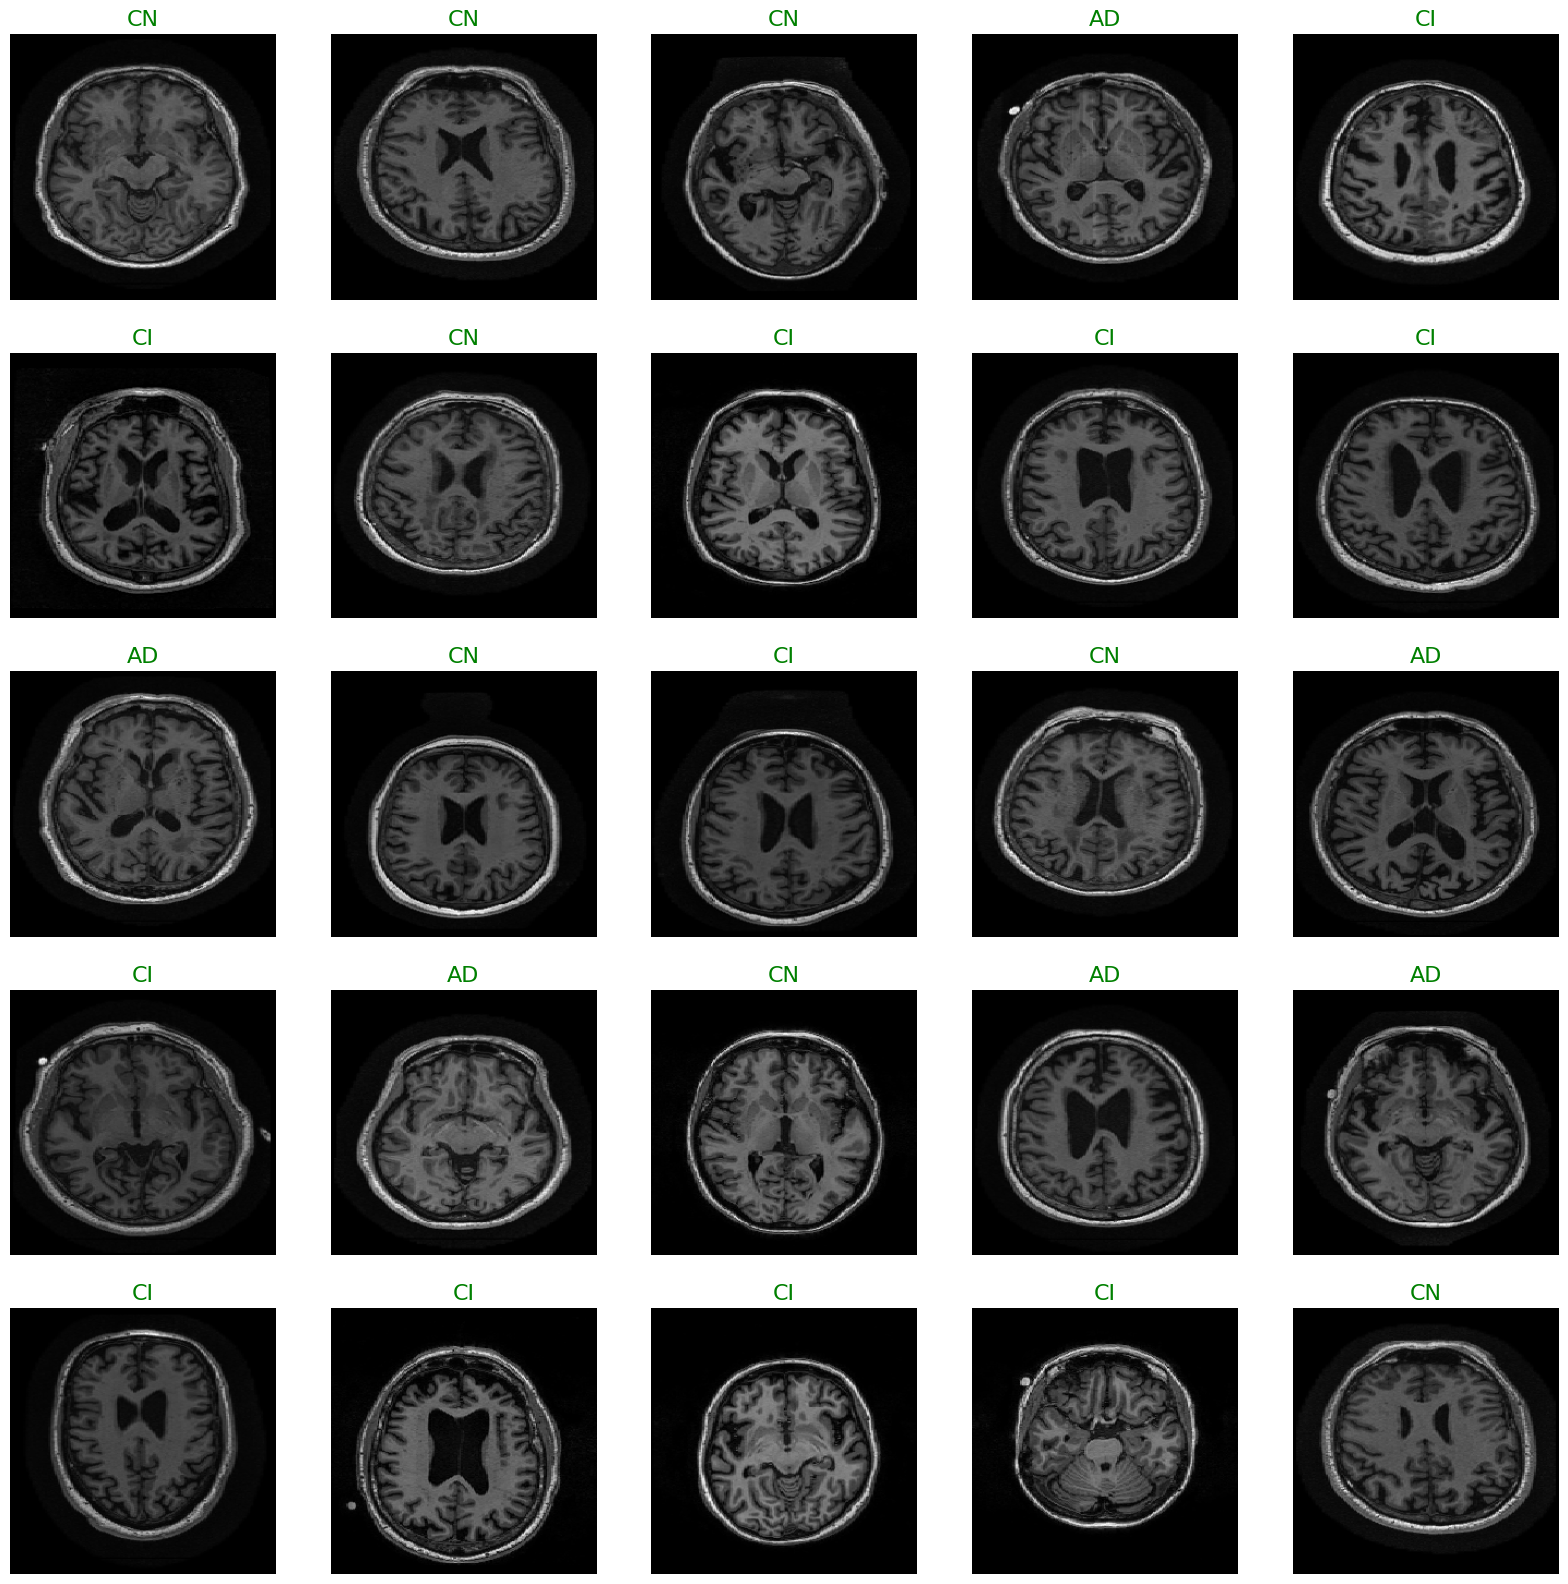

In [ ]:
# Displays a grid of sample images from the training set
show_knee_images(train)

In [ ]:
# Defines a Convolutional Neural Network (CNN) model for multiclass classification
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

# Compiles the model with categorical crossentropy loss and SGD optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

# Displays the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 512)         │           2,0

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
# Trains the CNN model using the training and validation data
history = model.fit(train, epochs=22, validation_data=val, validation_freq=1)

Epoch 1/22


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 55s 305ms/step - accuracy: 0.4118 - loss: 1.9204 - val_accuracy: 0.4665 - val_loss: 1.1142
Epoch 2/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.5619 - loss: 1.0365 - val_accuracy: 0.4617 - val_loss: 1.3708
Epoch 3/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.6953 - loss: 0.7060 - val_accuracy: 0.5199 - val_loss: 1.1382
Epoch 4/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.8022 - loss: 0.4947 - val_accuracy: 0.6043 - val_loss: 0.8226
Epoch 5/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.8965 - loss: 0.3024 - val_accuracy: 0.9370 - val_loss: 0.2412
Epoch 6/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9386 - loss: 0.1942 - val_accuracy: 0.9796 - val_loss: 0.0967
Epoch 7/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9629 - loss: 0.1189 - val_accuracy: 0.9903 - val_loss: 0.0598
Epoch 8/22
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9797 - loss: 0.0772 - val

In [ ]:
# Evaluates the trained model on the test data
model.evaluate(test, verbose=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9964 - loss: 0.0083


[0.008223820477724075, 0.9967679381370544]

In [ ]:
# Saves the trained model to a file
model.save("alzheimer_model_cnn.h5")

In [ ]:
# Makes predictions on the test data and decodes the predicted class labels
pred = model.predict(test)
pred = np.argmax(pred, axis=1) # Picks class with highest probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step


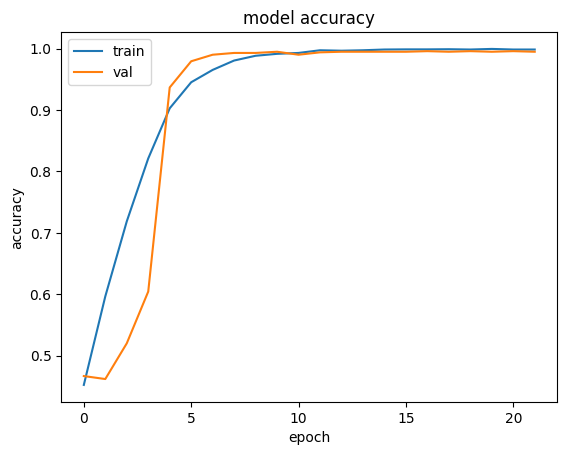

In [ ]:
# Plots the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

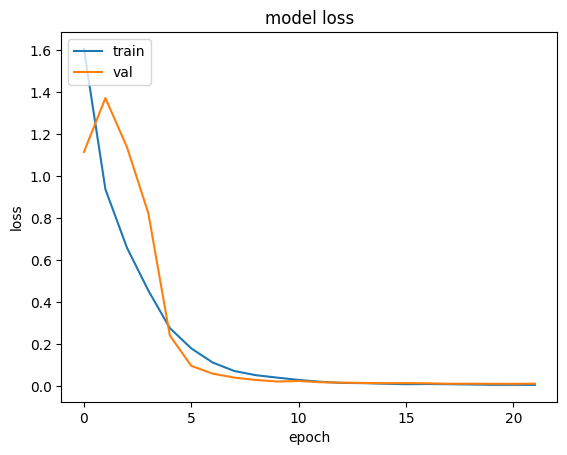

In [ ]:
# Plots the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Calculates and displays the classification report and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # Sets y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

          AD       1.00      0.99      0.99       357
          CI       1.00      1.00      1.00       734
          CN       1.00      1.00      1.00       456

    accuracy                           1.00      1547
   macro avg       1.00      1.00      1.00      1547
weighted avg       1.00      1.00      1.00      1547

Accuracy of the Model: 99.7%


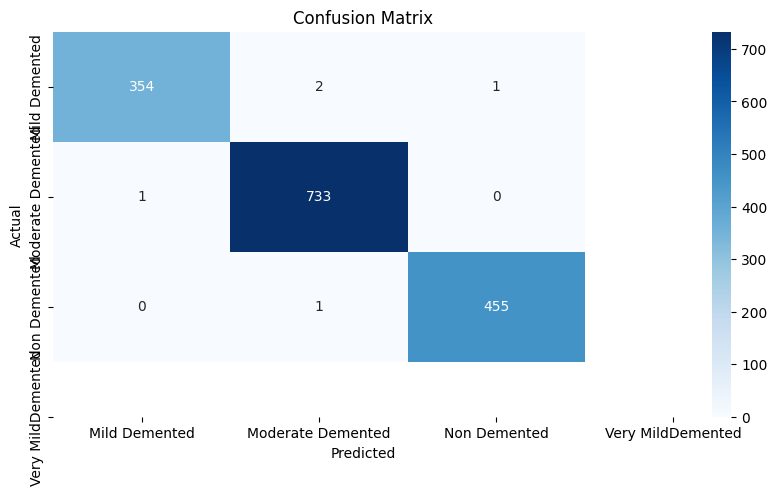

In [ ]:
# Defines the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculates the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Creates a figure and plots the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Sets tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Sets the title
plt.title("Confusion Matrix")

# Shows the plot
plt.show()